# Random forest

[Updated 4/9/2025]
max_features for tf was reduced from init 10000 to 2000/3000. Avoid overfitting. Memory hit.


Tests Random Forest using:

    TF-IDF with different max_features (e.g., 1000, 2000, 3000)

    +/− style features

    With RandomOverSampler (ROS)

    With or without lemmatization (optional)

    Logs all results for comparison

Random Forest doesn't benefit much from it, and it's slower with dense matrices. But we can still test one lemmatized version.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack, csr_matrix
import pandas as pd
from src.utils import metrics, plot_confusion_matrix, store_metrics

results = []

train_df = pd.read_csv("data/byarticle_clean.tsv", sep="\t")
test_df = pd.read_csv("data/byarticle_clean_test.tsv", sep="\t")

train_df_lem = pd.read_csv("data/byarticle_train_lemmatized.tsv", sep="\t")
test_df_lem = pd.read_csv("data/byarticle_test_lemmatized.tsv", sep="\t")


=== Running: Random Forest - TF-IDF(1000) + ROS ===
Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.81
Recall: 0.69
F1: 0.75
AUC: 0.85


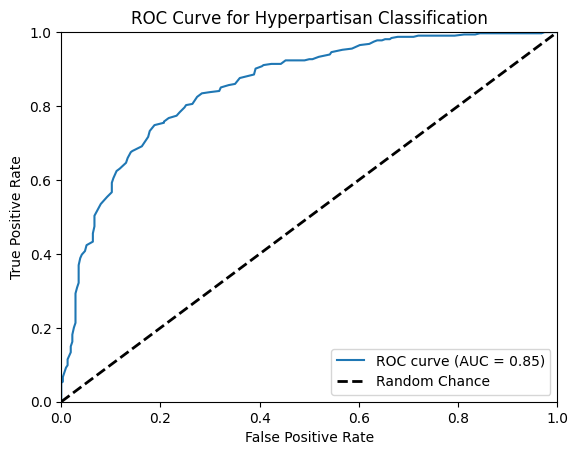

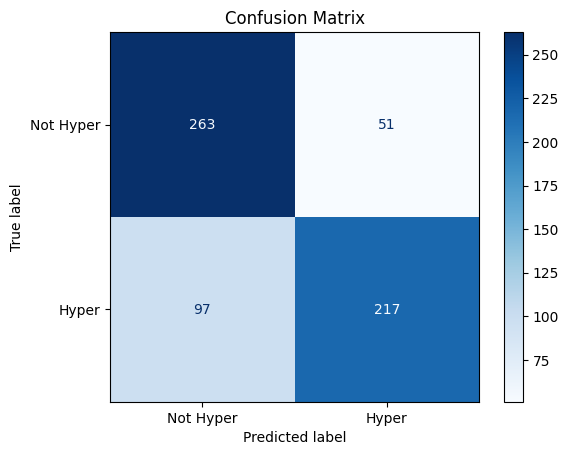


=== Running: Random Forest - TF-IDF(1000) + ROS + Style ===
Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.80
Recall: 0.69
F1: 0.74
AUC: 0.85


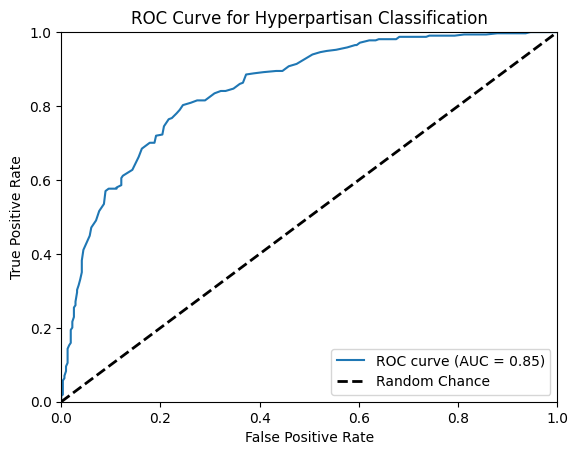

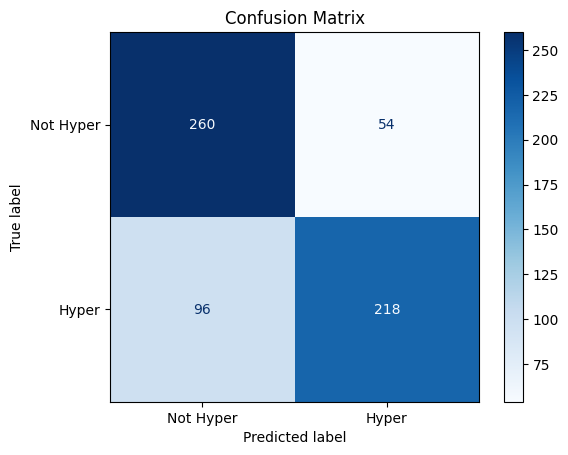


=== Running: Random Forest - TF-IDF(2000) + ROS ===
Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.80
Recall: 0.69
F1: 0.74
AUC: 0.84


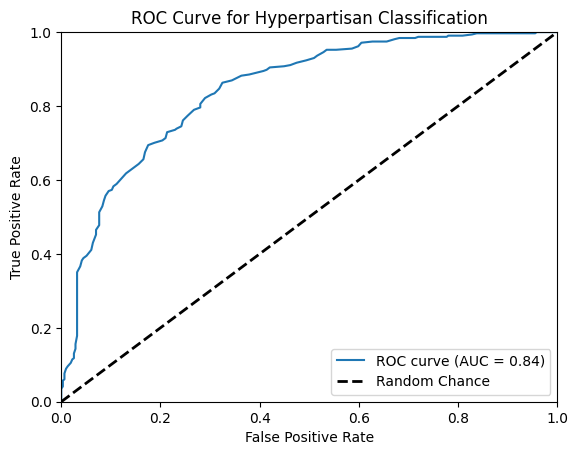

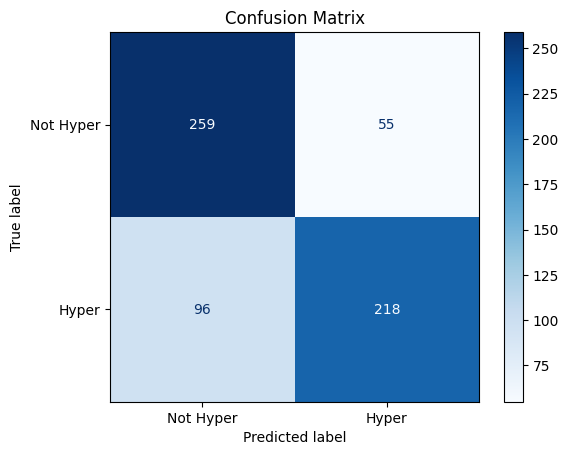


=== Running: Random Forest - TF-IDF(2000) + ROS + Style ===
Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.81
Recall: 0.68
F1: 0.74
AUC: 0.85


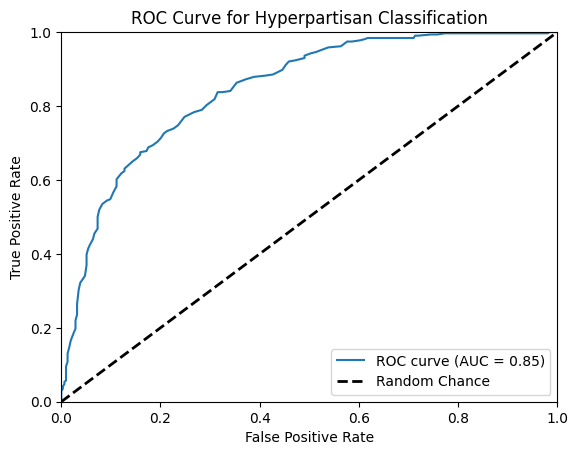

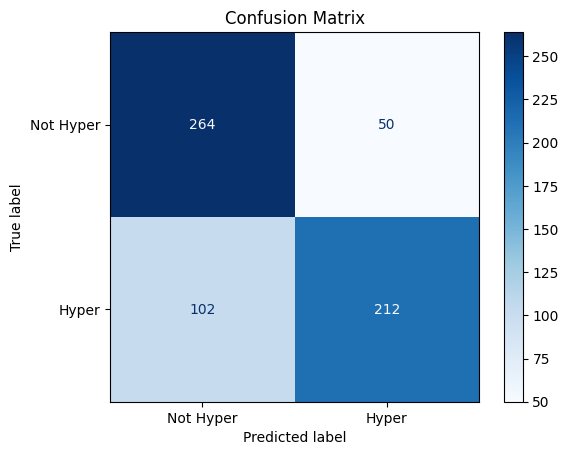


=== Running: Random Forest - TF-IDF(3000) + ROS ===
Accuracy: 0.75
Balanced Accuracy: 0.75
Precision: 0.80
Recall: 0.67
F1: 0.73
AUC: 0.84


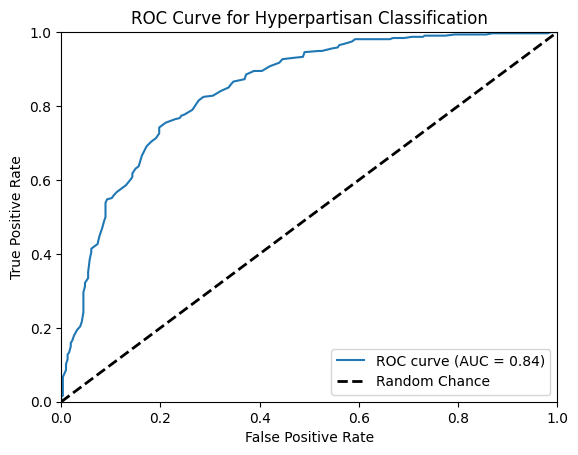

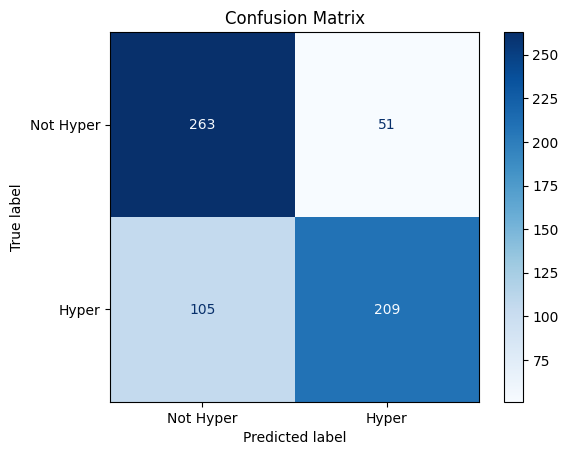


=== Running: Random Forest - TF-IDF(3000) + ROS + Style ===
Accuracy: 0.76
Balanced Accuracy: 0.76
Precision: 0.81
Recall: 0.69
F1: 0.74
AUC: 0.85


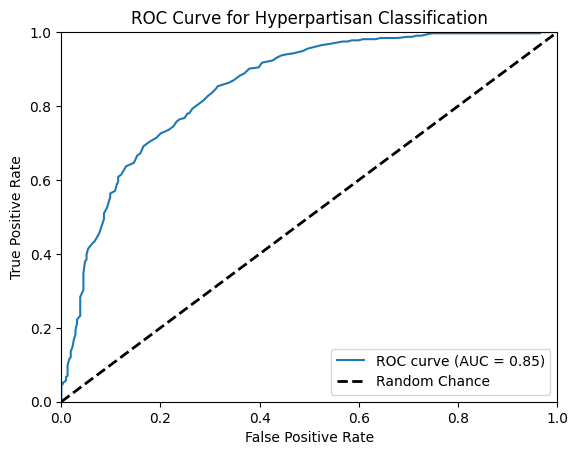

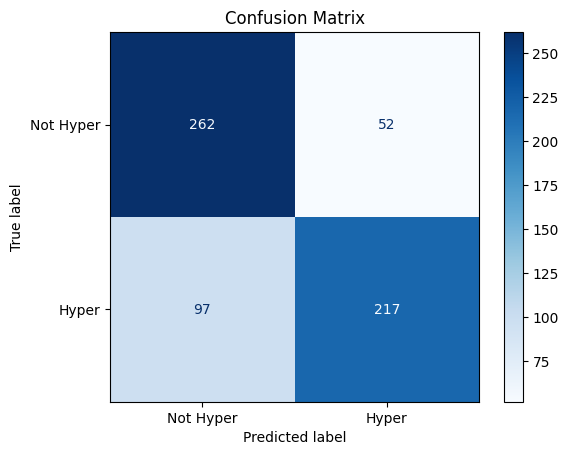

In [17]:
# Fixed inputs
y_train = train_df["label"]
y_test = test_df["label"]
X_train_text = train_df["full_text"]
X_test_text = test_df["full_text"]


# EXTRA TEST WITH LEMMATIZATION (otional)
#X_train_text = train_df_lem["lemmatized_text"]
#X_test_text = test_df_lem["lemmatized_text"]

style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']

# Parameters to test
feature_sizes = [1000, 2000, 3000]
use_styles = [False, True]

for max_feat in feature_sizes:
    for use_style in use_styles:
        setup_name = f"TF-IDF({max_feat}) + ROS"
        if use_style:
            setup_name += " + Style"

        print(f"\n=== Running: Random Forest - {setup_name} ===")

        # Vectorizer
        vectorizer = TfidfVectorizer(max_features=max_feat, stop_words="english", ngram_range=(1, 2))
        X_train_vec = vectorizer.fit_transform(X_train_text)
        X_test_vec = vectorizer.transform(X_test_text)

        # Add style if enabled
        if use_style:
            scaler = MinMaxScaler()
            X_train_style = csr_matrix(scaler.fit_transform(train_df[style_features]))
            X_test_style = csr_matrix(scaler.transform(test_df[style_features]))
            X_train_comb = hstack([X_train_vec, X_train_style])
            X_test_comb = hstack([X_test_vec, X_test_style])
        else:
            X_train_comb = X_train_vec
            X_test_comb = X_test_vec

        # Convert to dense
        X_train_comb_dense = X_train_comb.toarray()
        X_test_comb_dense = X_test_comb.toarray()

        # Apply ROS
        ros = RandomOverSampler(random_state=0)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train_comb_dense, y_train)

        # Train model
        rf = RandomForestClassifier(n_estimators=200, random_state=0)
        rf.fit(X_train_resampled, y_train_resampled)

        # Predict
        y_pred = rf.predict(X_test_comb_dense)
        y_proba = rf.predict_proba(X_test_comb_dense)[:, 1]

        # Evaluate
        metrics(y_test, y_pred, y_proba)
        plot_confusion_matrix(y_test, y_pred)
        store_metrics(results, "Random Forest", setup_name, y_test, y_pred, y_proba)


In [18]:
# === Final comparison table
results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df.to_string(index=False))


=== Comparison Table ===
        Model                                      Setup  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score   AUC
Random Forest                         TF-IDF(1000) + ROS     0.760              0.760      0.810   0.678     0.738 0.840
Random Forest                 TF-IDF(1000) + ROS + Style     0.748              0.748      0.802   0.659     0.724 0.841
Random Forest                         TF-IDF(2000) + ROS     0.768              0.768      0.818   0.688     0.747 0.850
Random Forest                 TF-IDF(2000) + ROS + Style     0.768              0.768      0.816   0.691     0.748 0.844
Random Forest                         TF-IDF(3000) + ROS     0.756              0.756      0.797   0.688     0.738 0.849
Random Forest                 TF-IDF(3000) + ROS + Style     0.755              0.755      0.794   0.688     0.737 0.839
Random Forest         TF-IDF(1000) + ROS + lemmetization     0.764              0.764      0.810   0.691     0.746 0.853
Random

# Analyze

TF-IDF(2000) consistently performs best

    The sweet spot for RF — likely because of the balance between feature richness and overfitting risk

    Better than both 1000 and 3000 in most cases

 Style features help — but not always

    They improve F1 and AUC only when paired with ROS and mid-sized TF-IDF

    May slightly hurt with small vocab sizes (1000 + Style = slight drop)

 Lemmatization helps somewhat — not game-changing

    +0.001–0.003 on F1 in the best cases

    More helpful with smaller vocab sizes, less so with 2000–3000 TF-IDF

In [19]:
result = [row for row in results if row["Setup"] == "TF-IDF(2000) + ROS + Style"]
df_single = pd.DataFrame(result)
df_single.to_csv("results/byarticleBaseline_results_sepTest.csv", mode='a', index=False, header=False)